In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython
import IPython.display
import os

import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
from profiling import cumTimer

In [3]:
print(tf.__version__)

2.6.0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

3 Physical GPUs, 3 Logical GPUs


True

# Import Data

In [5]:
InputData = np.genfromtxt('Data/InputDataBenchmark.csv',delimiter=",")
t = np.genfromtxt('Data/timeBenchmark.csv',delimiter=",")
Data = np.genfromtxt('Data/OutputDataBenchmark.csv',delimiter=",")
print(f"OutData: %s, \nInputData: %s, \nTime: %s" %(np.shape(Data),np.shape(InputData),np.shape(t)))

OutData: (400, 28), 
InputData: (28, 6), 
Time: (400,)


# Split The Data

In [6]:
n = Data.shape[1]
train_df = Data[:, 0:int(n*0.7):]
val_df = Data[:,int(n*0.7):int(n*0.9):]
test_df = Data[:,int(n*0.9):]

num_features = Data.shape[1]


# Normalize Data

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

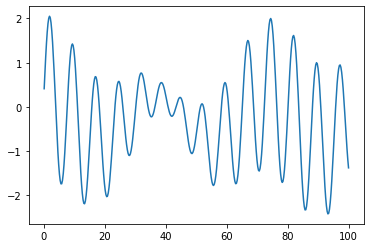

In [8]:
example_ind = 4
plt.plot(t,val_df[:,example_ind])


# Data Windowing

In [9]:
from window import WindowGenerator

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]

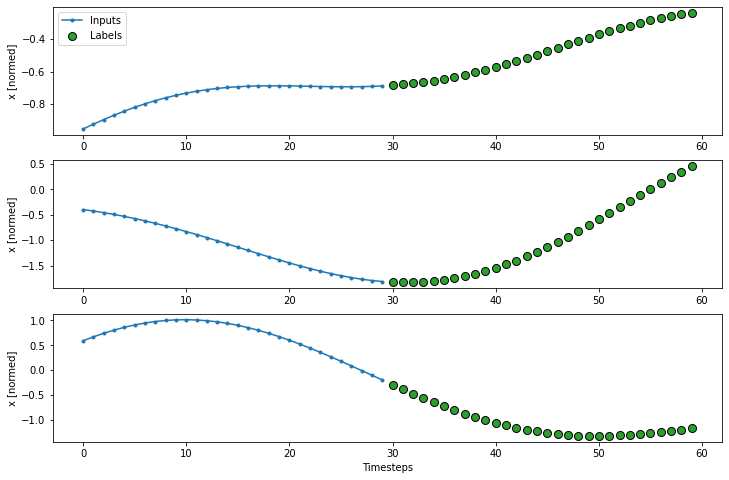

In [10]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df,
                               batch_size = 1000)

multi_window.plotexample()
multi_window

# FeedBack Model

In [41]:
from network import FeedBack, lstm_model

In [12]:
model =  FeedBack(units=101, out_steps=OUT_STEPS)
model(multi_window.example[0]).shape

TensorShape([1000, 30, 1])

In [47]:
model2 = lstm_model(return_states=False)

In [13]:
models = os.listdir("Models/")
print(models)
print(f"Models/{models[4]}")

['LSTM_AR100_Dropout@50@08-01-2022-21:43.h5', 'LSTM@500@09-01-2022-02:58.h5', 'LSTM@500@09-01-2022-02:58.h5AR@5009-01-2022-03:08.h5', 'feedbackWeights.h5', 'LSTM@500@09-01-2022-04:02.h5', 'LSTM@500@16-01-2022-23:42.h5', 'LSTM_AR100_Dropout@50@17-01-2022-00:35.h5', 'LSTM_AR100_Dropout@50@17-01-2022-00:58.h5', 'LSTM_AR100_Dropout@50@17-01-2022-01:14.h5', 'LSTM_AR100_Dropout@50@17-01-2022-01:25.h5', 'LSTM_AR100_Dropout@50@17-01-2022-04:44.h5', 'feedbackWeights2.h5', 'LSTM_AR100_Dropout@50@17-01-2022-23:53.h5', 'feedbackWeights3.h5', 'LSTM_AR100_Dropout@50@20-01-2022-16:36.h5', 'LSTM@500@20-01-2022-18:37.h5', 'LSTM@500@20-01-2022-18:38.h5', 'BenchmarkLSTM@500@20-01-2022-18:40.h5', 'BenchmarkLSTM@800@20-01-2022-18:40.h5']
Models/LSTM@500@09-01-2022-04:02.h5


In [14]:
model.load_weights(f"Models/BenchmarkLSTM@800@20-01-2022-18:40.h5")

# Plot Case

In [27]:
val_df[:,0].shape

(400,)

In [32]:
%%time
predictions = multi_window.CalcCase(val_df[:,0],t,model)

CPU times: user 2.21 s, sys: 35.7 ms, total: 2.24 s
Wall time: 2.14 s


In [33]:
example_ind = 2

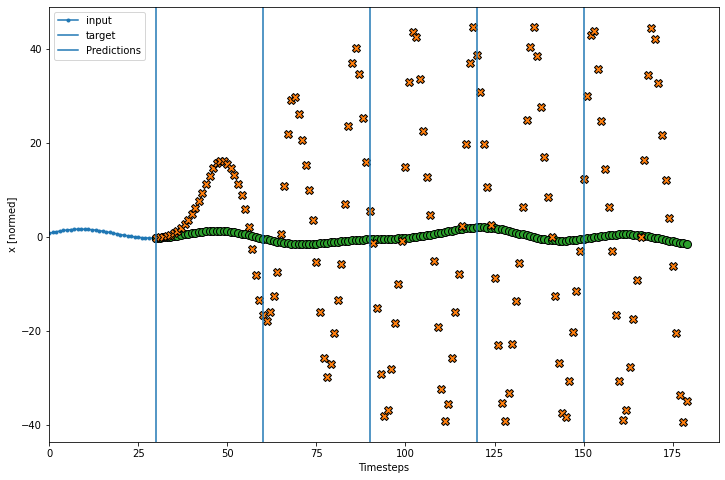

In [34]:
steps = 5
predictions = multi_window.plotCase(val_df[:,example_ind],t[:multi_window.input_width+multi_window.label_width*steps],model)

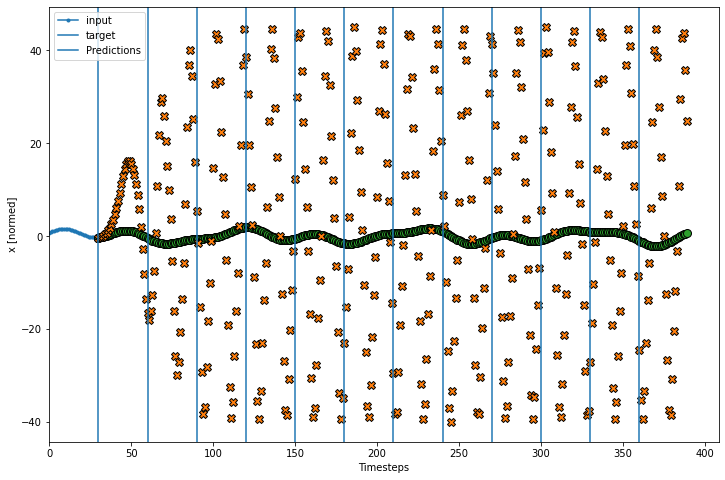

In [36]:
predictions = multi_window.plotCase(val_df[:,example_ind],t,model)

# Create Animation

In [37]:
from alive_progress import alive_bar

In [38]:
from pltfigure import pltfigure
def animateDataset(dataset,timesteps,name):
    predData = []
    tFinal = multi_window.input_width+multi_window.label_width*timesteps
    with alive_bar(dataset.shape[1]) as bar:
        for i in range(dataset.shape[1]):
            print("\nTest Case:{}".format(i))
            testCase = dataset[:,i]
            ts  = multi_window.CalcCase(testCase,t[:tFinal],model)
            predData.append(ts)
            bar()
        predData =np.array(predData)
    pltfigure(dataset[:tFinal,:].T,predData,range(tFinal),"Data","Prediction",name)

on 0: Test Case:0
on 1: Test Case:1
on 2: Test Case:2
on 3: Test Case:3
on 4: Test Case:4
on 5: Test Case:5
|████████████████████████████████████████| 6/6 [100%] in 5.1s (1.17/s)


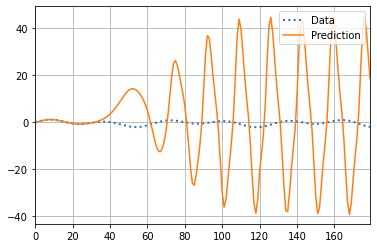

MovieWriter PillowWriter unavailable; using Pillow instead.


In [40]:
steps = 5
animateDataset(val_df,steps,f"Graphs/Prediction@{steps}Steps.gif")

# TESTING

In [89]:
pred , state = model(multi_window.example[0])

In [112]:
data1,state = model(pred,carry_states = state,out_steps=100)
data2,state = model(pred,out_steps =100)